# Examining trends in charitable finances over time

Import the libraries we need for the processing

In [1]:
%matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

# tqdm progress for downloading files customized from 
# https://raw.githubusercontent.com/tqdm/tqdm/master/examples/tqdm_wget.py
from urllib.request import urlretrieve
from os import devnull
from tqdm import tqdm

def my_hook(t):
    """Wraps tqdm instance.

    Don't forget to close() or __exit__()
    the tqdm instance once you're done with it (easiest using `with` syntax).

    Example
    -------

    >>> with tqdm(...) as t:
    ...     reporthook = my_hook(t)
    ...     urllib.urlretrieve(..., reporthook=reporthook)

    """
    last_b = [0]

    def update_to(b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return update_to


class TqdmUpTo(tqdm):
    """Alternative Class-based version of the above.

    Provides `update_to(n)` which uses `tqdm.update(delta_n)`.

    Inspired by [twine#242](https://github.com/pypa/twine/pull/242),
    [here](https://github.com/pypa/twine/commit/42e55e06).
    """

    def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)  # will also set self.n = b * bsize


        
def tqdm_wget(link):
    """
    Download link, and save in output, showing progress along the way
    """
    eg_link = link
    eg_file = eg_link.replace('/', ' ').split()[-1]
    eg_out = eg_link.split('/')[-1]

    with TqdmUpTo(unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
                  desc=eg_file) as t:  # all optional kwargs
        urlretrieve(eg_link, filename=eg_out, 
                    reporthook=t.update_to,data=None)

## Acquiring the data: 

We can download the CSV data files from the NCCS using our helper function:

In [ ]:
for year in range(1989, 2015):
    tqdm_wget('http://nccs-data.urban.org/'
              'data/core/{0}/nccs.core{0}pc.csv'.format(year))

## Cleaning and processing the data: 

We build up the year-by-year dataset from the downloaded .csv files. There area few idiosyncrasies with column names and capitalization throughout the years, which explains some of the extra code in the processing below: 

In [ ]:
time_df = pd.DataFrame()
to_analyze = list(test_pc_df.groupby('NTEECC').sum()['CONT']\
                    .sort_values(ascending=False)[:].index)

# Had to manually remove a non-ascii character from 2007 datafile on line 83072
for y in tqdm(range(1989,2016)):
    df = pd.read_csv('nccs.core{}pc.csv'.format(y))
    try:
        ntee1 = 'NTEE1'
        _ = df[ntee1]
    except Exception:
        print('no NTEE1')
        ntee1 = 'ntee1'
        df[ntee1.upper()] = df[ntee1]
    try:
        nteecc = 'NTEECC'
        df = df[df[nteecc].isin(to_analyze)]
    except Exception:
        nteecc = 'nteecc'
        df = df[df[nteecc].isin(to_analyze)]
        df[nteecc.upper()] = df[nteecc]

    # ZIP5 is mislabeled in 2004:
    if y == 2004:
        df['ZIP5'] = df['Zip5']

    # from 2011 onward, DUES is included in PROGREV:
    if y < 2011:
        df['PROGREV_TOT'] = df['PROGREV'] + df['DUES']
    else:
        df['PROGREV_TOT'] = df['PROGREV']

    df = df[['EIN', 'STATE', 'CITY', 'ZIP5', ntee1.upper(), nteecc.upper(), 
             'CONT', 'PROGREV_TOT', 'EXPS', 'TOTREV', 'FUNDBAL']]
    df['year'] = y
    time_df = pd.concat([time_df, df], axis=0, ignore_index=True)

time_df

To make it easier to use this dataset directly, we save it to disk as a compressed binary:

In [ ]:
time_df.to_hdf('year_by_year_DataFrame.h5','data')

## Analyzing the data over time

Load in the dataset that was processed from individual .csv files (downloaded from the NCCS) and
clean up a few rows that were dirty:

In [2]:
df = pd.read_hdf('year_by_year_DataFrame.h5')

In [3]:
# Drop some erroneous data:
df = df[df['NTEE1'].isin(['r','w']) == False]## Which sectors have grown the most?

Group the data by the year (from 1989 - 2015) and by the NTEE 1st digit code, which represents the sector of each non-profit in the dataset. From this grouping, we calculate the average of each value, and pull out a few values, such as total contributions, program revenue, expenditures, total revenue, and total asset balance:

In [4]:
grouped_df = df.groupby(['year', 'NTEE1']).mean()[['CONT', 'PROGREV_TOT', 'EXPS', 'TOTREV', 'FUNDBAL']]

To compare this data over time, we normalize the changes that are observed in each year by the data from the first available year (1989). This allows each business sector to be compared more easily: 

In [5]:
# Create a new dataframe, normalized by the 1989 data:
normed_df = grouped_df.copy(deep=True)
for y in grouped_df.index.get_level_values(0).unique():
    normed_df.loc[y] = grouped_df.loc[y].div(grouped_df.loc[1989]).values

In [6]:
normed_df.tail()

CONT  PROGREV_TOT      EXPS    TOTREV   FUNDBAL
year NTEE1                                                     
2015 V      4.315677     1.622531  3.097337  3.245872  5.600816
     W      1.881296     1.003028  1.271658  1.253509  2.079294
     X      1.584861     0.804284  1.230245  1.212239  1.317668
     Y      0.954110     0.086277  0.069807  0.077852  0.701898
     Z      1.565237     1.610644  1.441154  1.543682  2.372308

To assist in the plotting, put together a dictionary to map from the NTEE letter codes to their actual meanings. This makes the resulting plot more easily interpretable.

In [7]:
category_dict = \
{
    'A': 'Arts & Culture',
    'B': 'Education',
    'C': 'Environmental',
    'D': 'Animal Related',
    'E': 'Health Care',
    'F': 'Mental Health',
    'G': 'Disease & Disorder',
    'H': 'Medical Research',
    'I': 'Crime & Legal',
    'J': 'Employment',
    'K': 'Food & Nutrition',
    'L': 'Housing & Shelter',
    'M': 'Public Safety',
    'N': 'Recreation & Sport',
    'O': 'Youth Development',
    'P': 'Human Services',
    'Q': 'International Development',
    'R': 'Civil Rights',
    'S': 'Community Improvement',
    'T': 'Philanthropy',
    'U': 'Science and Technology',
    'V': 'Social Science',
    'W': 'Public Society Benefit',
    'X': 'Religion & Churches',
    'Y': 'Membership Associations',
    'Z': 'Unknown',
}

Finally, plot the most recent year's data, which is normalized to that of 1989. By using a bar chart, we can easily analyze how the different financial metrics for each non-profit sector have changed on a national scale over time:

In [8]:
cont_change = normed_df.loc[2015][['CONT', 'PROGREV_TOT', 'TOTREV','EXPS']]
cont_change.plot(kind='barh')
plt.xlabel('Growth multiple from 1989 - 2015')
plt.ylabel('NTEE Sector Category')
locs, labels = plt.yticks()
labels = [l.get_text() + ': ' + category_dict[l.get_text()] for l in labels]
plt.yticks(locs, labels);
plt.legend(['Contributions', 'Program Revenue', 'Total Revenue', 'Expenses'])

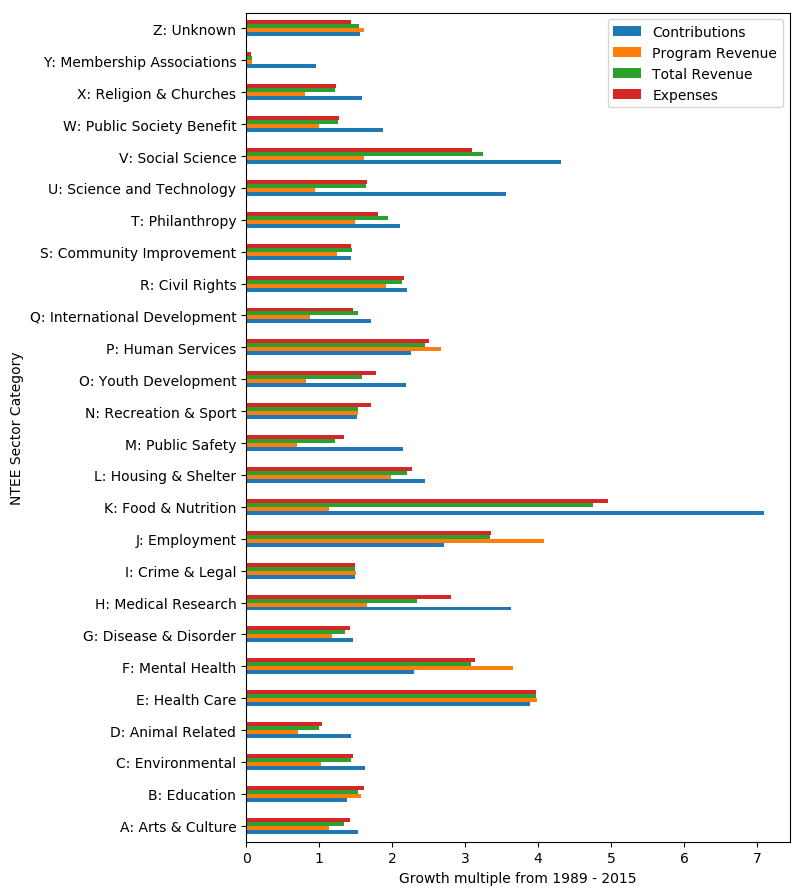

In [9]:
plt.gcf()

** A few takeaways can be gleaned from this plot: **

* For many sectors (A, B, C, etc.), the mean dollar values in both revenues and expenditures have not grown significantly over 26 years, especially since these values are not adjusted for inflation
* In others (E - Health care, K - Food and nutrition programs, etc.) the growth has been massive, ranging from 4 to 7 times the 1989 levels
* For many sectors, there has been a shift in revenues over the past 26 years from program-based revenues to contribution-based (evidenced by a large blue bar and small orange bar in the above plot)
    * This effect appears particularly strong for the research categories (H, U, and V), as well as K (Food assistance) and O (Youth development)